# 01 — Greeks & Sensitivities

## Objectives
- Define the main Greeks: Delta, Gamma, Vega, Theta, Rho
- Provide intuition behind each Greek
- Compute analytical Greeks under Black–Scholes (calls & puts)
- Visualize Greeks using Plotly
- Validate Greeks numerically using finite differences
- Link Greeks to hedging intuition (delta hedge, vega hedge, gamma risk)

**Key idea:** Greeks are local sensitivities. Hedging is managing Greeks, not prices.

##### Imports

In [4]:
import sys
sys.path.insert(0, str(Path.cwd().resolve().parents[1]))

import numpy as np
from pathlib import Path
from scipy.stats import norm
import plotly.graph_objects as go
from option_pricing.engines.analytics_bs import (bs_d1_d2, bs_call, bs_put)
from option_pricing.utils.plotly_helpers import line_plot, multi_line_plot

#### 1. Setup and Notation

We assume the Black–Scholes model with:
- Spot: $S_T$
- Strike: $K$
- Maturity: $T$
- Risk-free rate: $r$
- Constant volatility: $sigma$

We focus on **European** options and use **analytical Greeks** when available.

**Conventions:**
- Theta is reported as $( \partial V / \partial T ) $ with **time-to-maturity** $(T)$.
  This means Theta for a long option is typically **negative** (time decay).
- Vega is reported per **1.0 volatility unit** (i.e., per +100% absolute vol). We can scale it per 1% vol by dividing by 100.


#### 2. Greeks Implementation

In [5]:
def delta_call(S, K, T, r, sigma):
    d1, _ = bs_d1_d2(S, K, T, r, sigma)
    return norm.cdf(d1)

def delta_put(S, K, T, r, sigma):
    d1, _ = bs_d1_d2(S, K, T, r, sigma)
    return norm.cdf(d1) - 1.0

def gamma(S, K, T, r, sigma):
    d1, _ = bs_d1_d2(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def vega(S, K, T, r, sigma):
    d1, _ = bs_d1_d2(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T)

def theta_call(S, K, T, r, sigma):
    d1, d2 = bs_d1_d2(S, K, T, r, sigma)
    term1 = -(S * norm.pdf(d1) * sigma) / (2.0 * np.sqrt(T))
    term2 = -r * K * np.exp(-r * T) * norm.cdf(d2)
    return term1 + term2

def theta_put(S, K, T, r, sigma):
    d1, d2 = bs_d1_d2(S, K, T, r, sigma)
    term1 = -(S * norm.pdf(d1) * sigma) / (2.0 * np.sqrt(T))
    term2 = +r * K * np.exp(-r * T) * norm.cdf(-d2)
    return term1 + term2

def rho_call(S, K, T, r, sigma):
    _, d2 = bs_d1_d2(S, K, T, r, sigma)
    return K * T * np.exp(-r * T) * norm.cdf(d2)

def rho_put(S, K, T, r, sigma):
    _, d2 = bs_d1_d2(S, K, T, r, sigma)
    return -K * T * np.exp(-r * T) * norm.cdf(-d2)

In [6]:
S0, K, T, r, sigma = 100, 100, 1.0, 0.02, 0.20

out = {
    "Call price": float(bs_call(S0, K, T, r, sigma)),
    "Put price": float(bs_put(S0, K, T, r, sigma)),
    "Delta (call)": float(delta_call(S0, K, T, r, sigma)),
    "Delta (put)": float(delta_put(S0, K, T, r, sigma)),
    "Gamma": float(gamma(S0, K, T, r, sigma)),
    "Vega": float(vega(S0, K, T, r, sigma)),
    "Theta (call)": float(theta_call(S0, K, T, r, sigma)),
    "Theta (put)": float(theta_put(S0, K, T, r, sigma)),
    "Rho (call)": float(rho_call(S0, K, T, r, sigma)),
    "Rho (put)": float(rho_put(S0, K, T, r, sigma)),
}
out


{'Call price': 8.916037278572539,
 'Put price': 6.93590460924807,
 'Delta (call)': 0.579259709439103,
 'Delta (put)': -0.420740290560897,
 'Gamma': 0.019552134698772795,
 'Vega': 39.104269397545586,
 'Theta (call)': -4.890625613061314,
 'Theta (put)': -2.9302282664478034,
 'Rho (call)': 49.00993366533776,
 'Rho (put)': -49.00993366533776}

#### Greek profiles vs Spot

We plot each Greek as a function of spot $(S)$, keeping other parameters fixed.

- Call delta transitions from 0 to 1 around the strike
- Gamma peaks near the strike (ATM)
- Vega also peaks near ATM
- Theta is typically negative for long options


In [15]:
S_grid = np.linspace(50, 150, 300)
params = dict(K=100, T=1.0, r=0.02, sigma=0.20)


#### Delta vs Spot

- Call delta is between 0 and 1.
- Put delta is between -1 and 0.

**Hedging intuition:**  Delta is the number of shares required (locally) to hedge a small spot move.


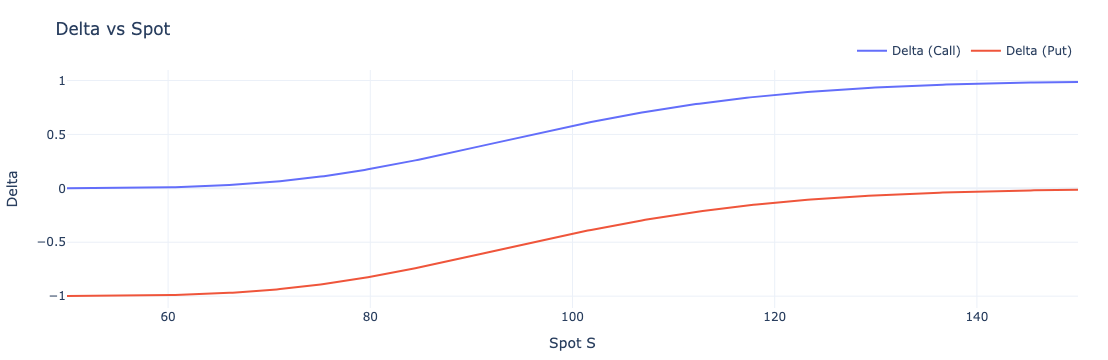

In [16]:
delta_call_vals = [delta_call(S, **params) for S in S_grid]
delta_put_vals  = [delta_put(S, **params) for S in S_grid]

fig = multi_line_plot(
    S_grid,
    {"Delta (Call)": delta_call_vals, "Delta (Put)": delta_put_vals},
    title="Delta vs Spot",
    xlab="Spot S",
    ylab="Delta"
)
fig.show()


#### Gamma vs Spot

Gamma measures curvature: how fast delta changes with spot.

**Intuition:**  High gamma (around ATM) means frequent rebalancing and larger hedging P&L.


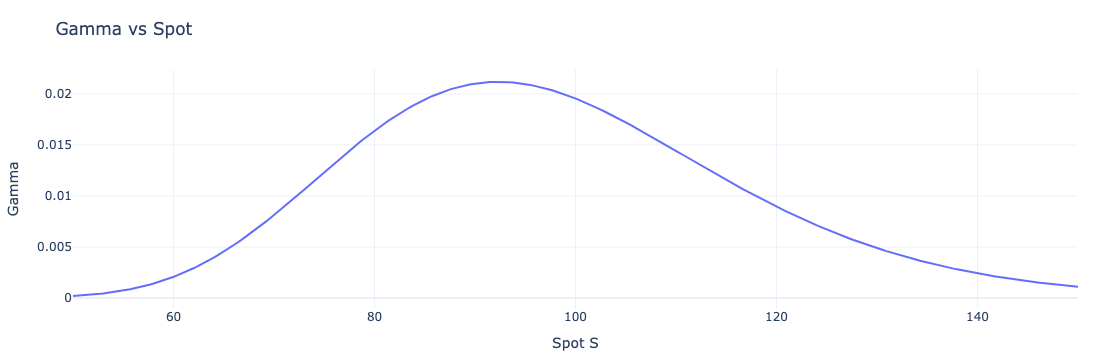

In [17]:
gamma_vals = [gamma(S, **params) for S in S_grid]
line_plot(S_grid, gamma_vals, "Gamma vs Spot", "Spot S", "Gamma", "Gamma").show()

#### Vega vs Spot

Vega measures sensitivity to volatility.

**Intuition:** Vega is hedged with liquid vanilla options (often ATM), not with the underlying.


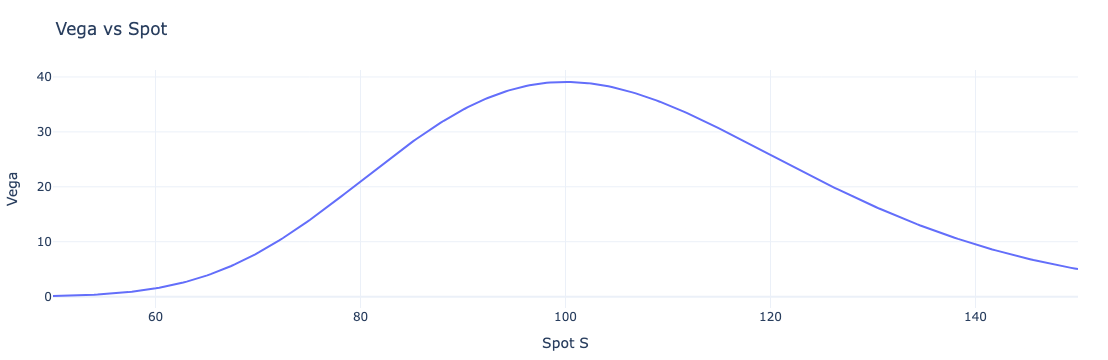

In [18]:
vega_vals = [vega(S, **params) for S in S_grid]
line_plot(S_grid, vega_vals, "Vega vs Spot", "Spot S", "Vega", "Vega").show()

#### Theta vs Spot

Theta is the sensitivity to time-to-maturity $(T)$.
For a long option, theta is typically negative (time decay).

**Note:**  Being long options usually means paying theta over time.


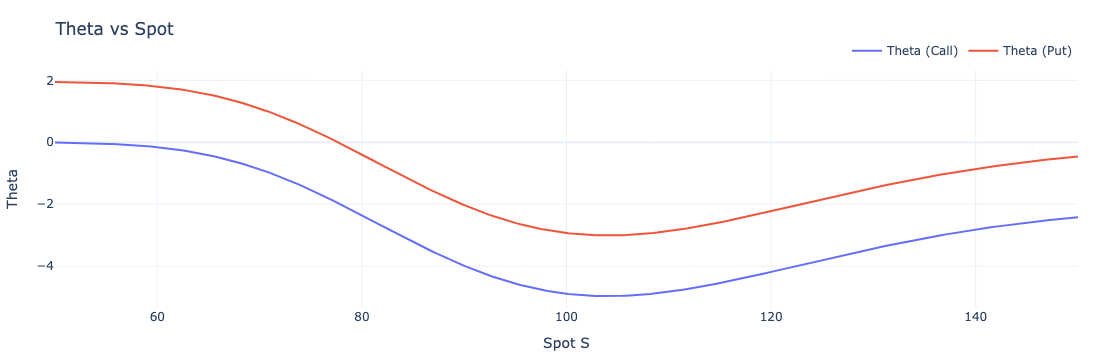

In [20]:
theta_call_vals = [theta_call(S, **params) for S in S_grid]
theta_put_vals  = [theta_put(S, **params) for S in S_grid]

fig = multi_line_plot(
    S_grid,
    {"Theta (Call)": theta_call_vals, "Theta (Put)": theta_put_vals},
    title="Theta vs Spot",
    xlab="Spot S",
    ylab="Theta"
)
fig.show()


#### Rho vs Spot

Rho measures sensitivity to the interest rate. It is often small for short-dated equity options but becomes relevant for long maturities and rates products.


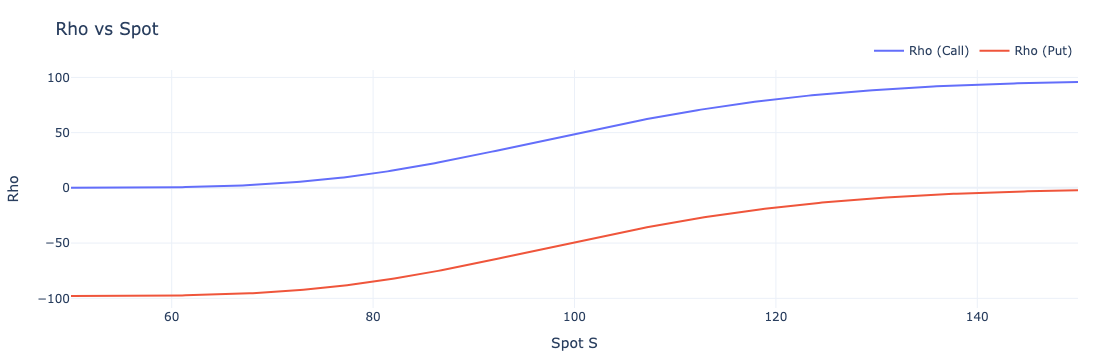

In [22]:
rho_call_vals = [rho_call(S, **params) for S in S_grid]
rho_put_vals  = [rho_put(S, **params) for S in S_grid]

fig = multi_line_plot(
    S_grid,
    {"Rho (Call)": rho_call_vals, "Rho (Put)": rho_put_vals},
    title="Rho vs Spot",
    xlab="Spot S",
    ylab="Rho"
)
fig.show()


#### Greeks vs Volatility and vs Maturity

 - Vega increases with maturity (more time for volatility to matter).
- Gamma typically decreases with maturity (curvature spreads out).


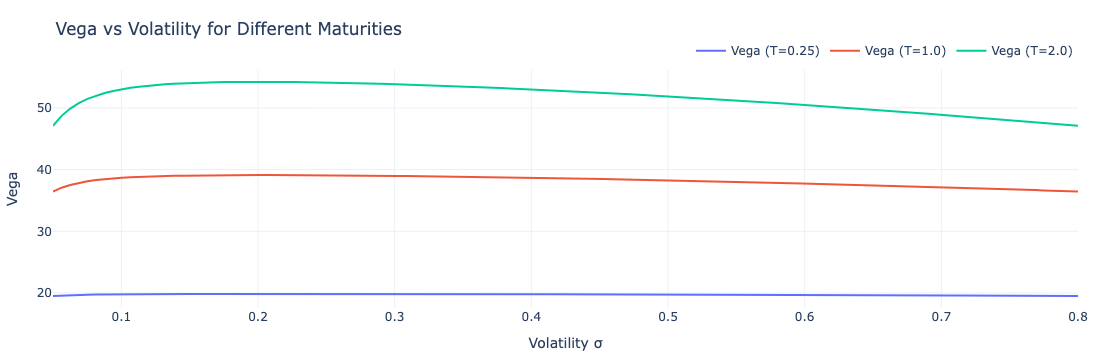

In [23]:
S0, K, r = 100, 100, 0.02
sigma_grid = np.linspace(0.05, 0.80, 120)
Ts = [0.25, 1.0, 2.0]  # 3M, 1Y, 2Y

series = {}
for T in Ts:
    series[f"Vega (T={T})"] = [vega(S0, K, T, r, s) for s in sigma_grid]

multi_line_plot(
    sigma_grid,
    series,
    title="Vega vs Volatility for Different Maturities",
    xlab="Volatility σ",
    ylab="Vega"
).show()


##  Summary

- **Delta**: hedge spot risk with the underlying
- **Gamma**: explains hedging P&L and rebalancing frequency
- **Vega**: hedge vol risk with vanillas (often ATM)
- **Theta**: time decay / carry
- **Rho**: rate exposure (important mainly for long-dated or rates products)
